<h1>Crime analysis</h1>
<p>This notebook is my first attempt at analyzing drug crime in San Francisco, the city in which I live. Credit to http://us-city.census.okfn.org/dataset/crime-stats for aggregating the links to crime databases at the city level. I focus on drug-related offenses in order to reduce the scope of the analysis.

In [8]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from mapboxgl import utils as mb_utils
from mapboxgl import viz as mb_viz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely import geometry

import datetime
from dateutil import parser as date_parser
import json
import os


MB_TOKEN = os.environ['MAPBOX_TOKEN']

<h3>Import the data</h3>
<p>Here, I am just importing the data and formatting it for ease of use. I also define a function to read in some geospatial data, to be used later, representing San Francisco neighborhoods along with data on their populations. You'll notice SFPD provides some interesting datapoints around time and location of the offense.

In [9]:
def get_sf_data():
    df = pd.read_csv('/data/crime/crime_sf_drug.csv')
    def parse_date_and_time(d, t):
        return date_parser.parse('{} {}'.format(d, t))
    df['datetime'] = df.apply(
        lambda x: parse_date_and_time(x['Date'], x['Time']), 
        axis=1)
    df['date'] = df.datetime.apply(lambda d: d.date())
    df['hour'] = df.datetime.apply(lambda d: d.hour)
    df['month'] = df.datetime.apply(lambda d: d.month)
    df['year'] = df.datetime.apply(lambda d: d.year)
    df['offense_code_group'] = df.Category
    df['offense_description'] = df.Descript
    df['day_of_week'] = df.DayOfWeek
    df['district'] = df.PdDistrict
    df['street'] = df.Address
    df['resolution'] = df.Resolution
    df['lat'] = df.Y
    df['long'] = df.X
    return df[['datetime', 
               'date', 
               'hour', 
               'month', 
               'year', 
               'offense_code_group', 
               'offense_description', 
               'resolution', 
               'day_of_week', 
               'district', 
               'street',
               'lat', 
               'long']]

def get_neighborhood_polygons():
    with open('/data/crime/neighborhoods.geojson') as f:
        data = json.load(f)
    return data

def get_neighborhood_populations():
    with open('/data/crime/neighborhood_populations.json') as f:
        data = json.load(f)
    return data


# read in the data for San Francisco drug crime
df = get_sf_data()
df.head(1)

,datetime,date,hour,month,year,offense_code_group,offense_description,resolution,day_of_week,district,street,lat,long
0,2015-02-01 14:00:00,2015-02-01,14,2,2015,DRUG/NARCOTIC,POSSESSION OF METH-AMPHETAMINE,"ARREST, BOOKED",Sunday,MISSION,1700 Block of HARRISON ST,37.769075,-122.413354


<h3>Mapping the data</h3>
<p>I wanted to visualize the data on a map to get a sense of the scope of the dataset. I use Mapbox's new iPython library to convert the dataframe into a GeoJSON file and then use that newly created file to create a cluster map visualization. 
    
For viewing purposes and simplicity, I've just embedded an image of the map.

In [ ]:
# dump the dataframe into a geojson file
mb_utils.df_to_geojson(df, 
                       filename='drug_crime_sf.geojson',
                       properties=['offense_code_group', 'offense_description', 'district', 'day_of_week', 'hour'],
                       lat='lat',
                       lon='long',
                       precision=6)

# use the newly created geojson data to create a cluster map
color_stops = mb_utils.create_color_stops([10, 100, 500, 1000], colors='YlOrRd')
radius_stops = [[1,5], [10, 10], [50, 15], [100, 20]]
cluster_viz_sf = mb_viz.ClusteredCircleViz('drug_crime_sf.geojson',
                                            access_token=MB_TOKEN,
                                            color_stops=color_stops,
                                            radius_stops=radius_stops,
                                            cluster_maxzoom=15,
                                            cluster_radius=30,
                                            zoom=11,
                                            center=(-122.4, 37.75))
cluster_viz_sf.show()

<img src="offense_map.png"/>

<h3>Drug offense categories</h3>
<p>Now I wanted to start digging into the actual offense types in the data. I examine the different offense descriptions below and create categories that I will leverage later. I'm showing just the top 5 most frequent offenses below for succinctness. </p>

In [10]:
df['offense_description'].value_counts().head(5)

POSSESSION OF NARCOTICS PARAPHERNALIA           22641
POSSESSION OF BASE/ROCK COCAINE                 14326
POSSESSION OF MARIJUANA                         11863
UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE     9771
SALE OF BASE/ROCK COCAINE                        9079
Name: offense_description, dtype: int64

In [11]:
desc = df.offense_description.unique()

alcohol = {x for x in desc if 'ALCOHOL' in x}
marijuana = {x for x in desc if 'MARIJUANA' in x}
cocaine = {x for x in desc if 'COCAINE' in x and 'BASE/ROCK' not in x}
crack = {x for x in desc if 'BASE/ROCK COCAINE' in x}
cocaine_crack = cocaine | crack
heroin = {x for x in desc if 'HEROIN' in x}
methadone = {x for x in desc if 'METHADONE' in x}
opiates = heroin | methadone | {x for x in desc if 'OPIATES' in x or 'OPIUM' in x}
hallucinogen = {x for x in desc if 'HALLUCINOGEN' in x or 'PEYOTE' in x}
meth = {x for x in desc if 'METH-AMPHETAMINE' in x}
amphetamine = meth | {x for x in desc if 'AMPHETAMINE' in x}

dui = {x for x in desc if 'DRIVING WHILE' in x}

possession = {x for x in desc if 'POSSESSION' in x and ' FOR SALE' not in x}
sale = {x for x in desc if ' FOR SALE' in x or 'SALE OF' in x}
transportation = {x for x in desc if 'TRANSPORTATION OF' in x}

<h3>Drug offenses over time</h3>
<p>One of the first things I wondered about this dataset was how marijuana related crimes were decreasing over time due to new legislation. I created a time-series plot of marijuana offenses and quickly noticed an aggressive downward trend. This got me wondering about the overall trend so I then created a time-series plot of everything (excluding marijuana) and again noticed a similar downward trend. After a Google search, I found a bunch of articles referencing SFPD's focus on serious and violent crime which has caused drug arrests to tumble.

In [12]:
df['year_mon'] = df.apply(lambda x: datetime.date(x['year'], x['month'], 1), axis=1)

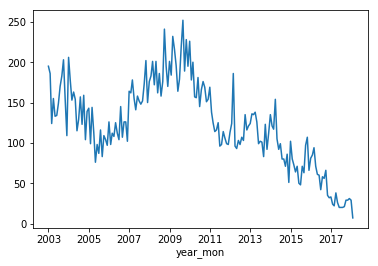

In [13]:
df[df.offense_description.isin(marijuana)].groupby('year_mon').size().plot()

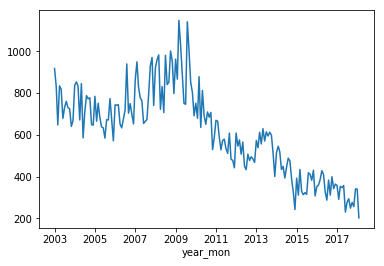

In [25]:
df[~df.offense_description.isin(marijuana)].groupby('year_mon').size().plot()

<h3>Drug offenses over time (cont.)</h3>
<p>I was curious to see how the different offense groupings I created above were changing in frequency over time. First, I group by drug type and create a time-series plot. Next, I group by offense type and create a time-series plot.</p>
<p>It was interesting to see how cocaine offenses have been decreasing significantly. Hallucinogens are by far the lowest used drug type.</p>

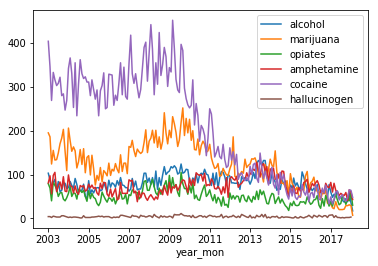

In [15]:
fig, ax = plt.subplots()

drug_groups = {'alcohol': alcohol, 
               'marijuana': marijuana, 
               'opiates': opiates, 
               'amphetamine': amphetamine, 
               'cocaine': cocaine_crack, 
               'hallucinogen': hallucinogen}
for dg_name, dg in drug_groups.items():
    df_g = df[df.offense_description.isin(dg)].groupby('year_mon').size()
    df_g.plot(ax=ax, kind='line', label=dg_name)

plt.legend()
plt.show()

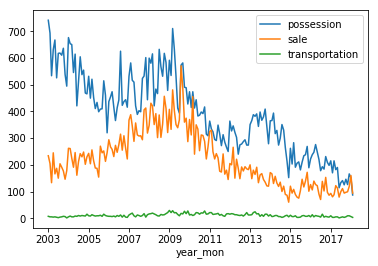

In [16]:
fig2, ax2 = plt.subplots()

off_groups = {'possession': possession, 'sale': sale, 'transportation': transportation}
for off_name, off in off_groups.items():
    df_g = df[df.offense_description.isin(off)].groupby('year_mon').size()
    df_g.plot(ax=ax2, kind='line', label=off_name)

plt.legend()
plt.show()

<h3>Day and time trends</h3>
<p>Here I was just curious to see which day of the week and time of the day had the most drug arrests. These numbers will be significantly impacted by a variety of factors (number of on duty police, the fact that most people are sleeping at 4am, etc) but I thought they were interesting nonetheless.</p>

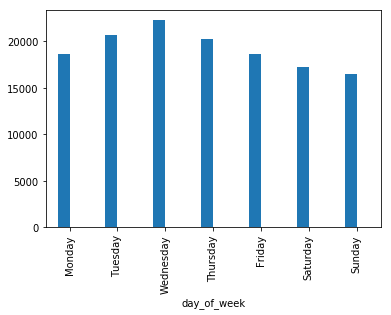

In [17]:
day_of_week = df.groupby('day_of_week').size().reset_index(name='count')
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
day_of_week['day_number'] = day_of_week.day_of_week.apply(lambda dow: day_map[dow])
day_of_week = day_of_week.sort_values('day_number').plot.bar(x='day_of_week', legend=False)

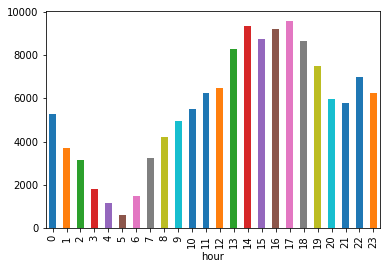

In [18]:
df.groupby('hour').size().plot.bar()

<h3>Drug arrests by neighborhood</h3>
<p>I was then curious about breaking arrests down by neighborhood but realized I only had the district where the offense occurred in my dataset. To remedy this, I found a website that was displaying San Francisco neighborhood boundaries and I borrowed their GeoJSON :). Once I had the neighborhood geometries, I wrote a function that, given a set of coordinates, finds the neighborhood geometry that contains those coordinates. I used that function to create a "local_neighborhood" column in my dataframe and then created a bar plot to show offense frequency per neighborhood. </p>
<p>The Tenderloin, the Mission, and SoMA were by far the leaders in drug offenses.</p>
    

In [19]:
df['coords'] = list(zip(df.lat, df.long))

In [20]:
def find_neighborhood_containing_point(coords, nhood_polygons):
    point = geometry.Point(coords[1], coords[0])
    for f in nhood_polygons['features']:
        polygon = geometry.shape(f['geometry'])
        if polygon.contains(point):
            hood = f['properties']['nhood']
            break
    else:
        hood = None
    return hood

In [21]:
neighborhood_polygons = get_neighborhood_polygons()
df['local_neighborhood'] = df.coords.apply(
    lambda coords: find_neighborhood_containing_point(coords, neighborhood_polygons))

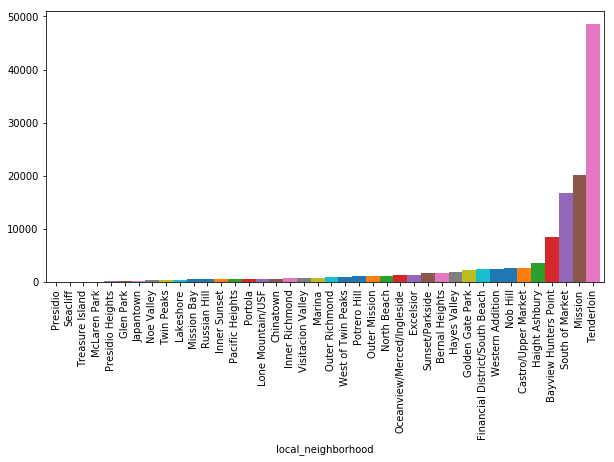

In [22]:
df.groupby('local_neighborhood').size().sort_values().plot.bar(width=1, figsize=(10, 5))

<h3>Drug arrests by neighborhood (cont.)</h3>
<p>Because some neighborhoods are much more populated than others, I decided to scrape neighborhood populations 
and then create the same plot per capita.</p>

In [23]:
neighborhood_populations = get_neighborhood_populations()

def append_neighborhood_population(local_neighborhood, neighborhood_populations):
    return neighborhood_populations.get(local_neighborhood)

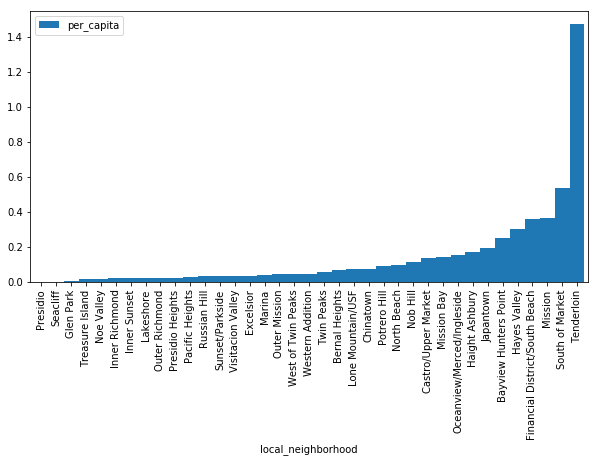

In [26]:
by_neighborhood = df.groupby('local_neighborhood').size().reset_index(name='count')
by_neighborhood['population'] = by_neighborhood.local_neighborhood.apply(
    lambda n: append_neighborhood_population(n, neighborhood_populations))
by_neighborhood = by_neighborhood.dropna(subset=['population'])
by_neighborhood['per_capita'] = by_neighborhood.apply(lambda n: n['count'] / n['population'], axis=1)

by_neighborhood[['local_neighborhood', 'per_capita']].sort_values(by=['per_capita']).plot.bar(
    x='local_neighborhood', width=1, figsize=(10, 5))

<h3>Drug arrests by neighborhood (cont.)</h3>
<p>Seeing arrests and arrests per capita in a plot really made me want to see the same data on a map by neighborhood. Below I added some of the columns from my neighborhood dataframe as properties to GeoJSON and again used Mapbox's library to create some choropleth visualizations. (Again, I embedded an image of the map for simplicity.)</p>


In [27]:
def get_neighborhood_density_polygons(df):
    df_hood_idx = df.set_index('local_neighborhood')
    neighborhood_density_polygons = {'type': 'FeatureCollection', 'features': []}
    for feature in neighborhood_polygons['features']:
        hood = feature['properties']['nhood']
        if hood in df_hood_idx.index:
            row = df_hood_idx.loc[hood]
            for col in ('population', 'count', 'per_capita'):
                feature['properties'][col] = row[col]
            neighborhood_density_polygons['features'].append(feature)
    return neighborhood_density_polygons

neighborhood_density_polygons = get_neighborhood_density_polygons(by_neighborhood)
with open('neighborhood_density_polygons.geojson', 'w') as f:
    json.dump(neighborhood_density_polygons, f)

# create choropleth from polygon features stored as GeoJSON
viz_choro = mb_viz.ChoroplethViz('neighborhood_density_polygons.geojson', 
                           access_token=MB_TOKEN,
                           color_property='count',
                           label_property='nhood',
                           color_stops=mb_utils.create_color_stops([100, 1000, 5000, 10000, 20000], colors='YlOrRd'),
                           color_function_type='interpolate',
                           line_stroke='--',
                           line_color='rgb(128,0,38)',
                           line_width=1,
                           opacity=0.7,
                           center=(-122.4, 37.75),
                           zoom=11,)
viz_choro.show()

<img src="offense_map_choropleth.png"/>

In [28]:
# adjust view angle
viz_choro.bearing = -15
viz_choro.pitch = 45

viz_choro.height_property = 'count'
viz_choro.height_stops = mb_utils.create_numeric_stops([100, 1000, 5000, 10000, 20000], 0, 1250)
viz_choro.height_function_type = 'interpolate'

# render
viz_choro.show()

<img src="offense_map_choropleth_pitched.png"/>

<h3>Offense type clustering</h3>
<p>Seeing the number of offenses per neighborhood got me thinking about which offenses were correlated to which neighborhoods so I created a clustermap of offense descriptions to neighborhoods, after normalizing the data.</p>

<p>This clustermap revealed some interesting relationships. It looks like Golden Gate Park is giving the local dispensaries a run for their money...</p>

In [29]:
df_t = df.groupby('offense_description').filter(lambda x: len(x) > 550)
df_t = df_t.groupby('local_neighborhood').filter(lambda x: len(x) > 910)

off_by_hood = df_t.groupby(['offense_description', 'local_neighborhood']).size().unstack().fillna(0)

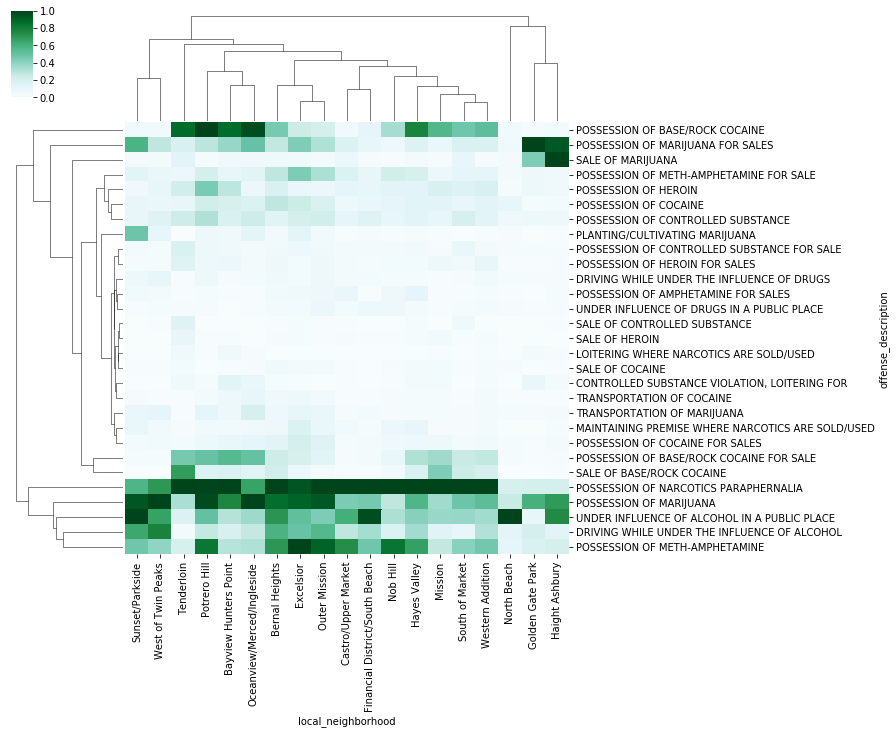

In [30]:
t = off_by_hood.reset_index().set_index('offense_description')
g = sns.clustermap((t - t.min()) / (t.max() - t.min()), 
                   cmap='BuGn')

<h3>Possession, Sale, Transportation</h3>
<p>Next, I wanted to find the neighborhoods with the highest frequency of possession offenses, intent to sell offenses, and transportation offenses. I created plots of the top 10 neighborhoods for each of the 3. Possession and intent to sell are very similar but transportation related offenses occur in different neighborhoods.</p>

In [31]:
df_poss = df[df.offense_description.isin(possession)]
df_sale = df[df.offense_description.isin(sale)]
df_tran = df[df.offense_description.isin(transportation)]

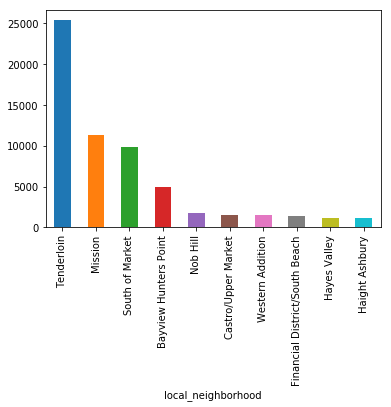

In [32]:
df_poss.groupby('local_neighborhood').size().nlargest(10).plot.bar()

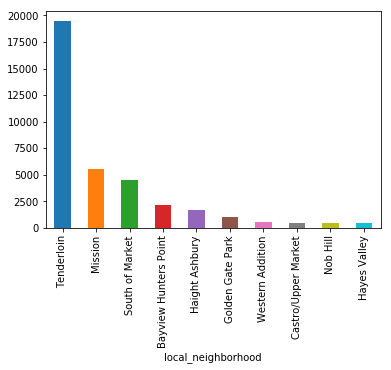

In [33]:
df_sale.groupby('local_neighborhood').size().nlargest(10).plot.bar()

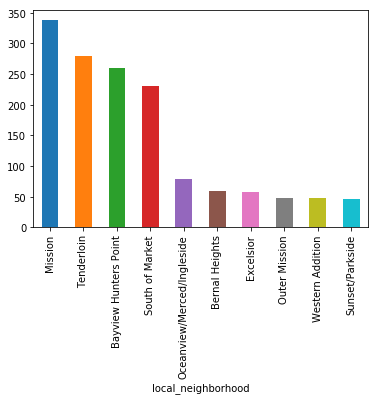

In [34]:
df_tran.groupby('local_neighborhood').size().nlargest(10).plot.bar()